# Data Analysis: Grammy Award Nominees and Winners, 1958-2024

### Import Libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [30]:
# Load the Grammy dataset
df = pd.read_csv("Grammy Award Nominees and Winners 1958-2024.csv")

# Drop unnecessary column
df.drop(columns=['Unnamed: 0'], inplace=True)

# Check for missing data
print(df.isnull().sum())

# Drop rows with missing 'Work'
df = df.dropna(subset=['Work'])  # Only if needed


Year            0
Ceremony        0
Award ID        0
Award Type      0
Award Name      0
Work          291
Nominee         0
Winner          0
dtype: int64


## Exploratory Data Analysis (EDA)

#### Top 10 Most Nominated Artists

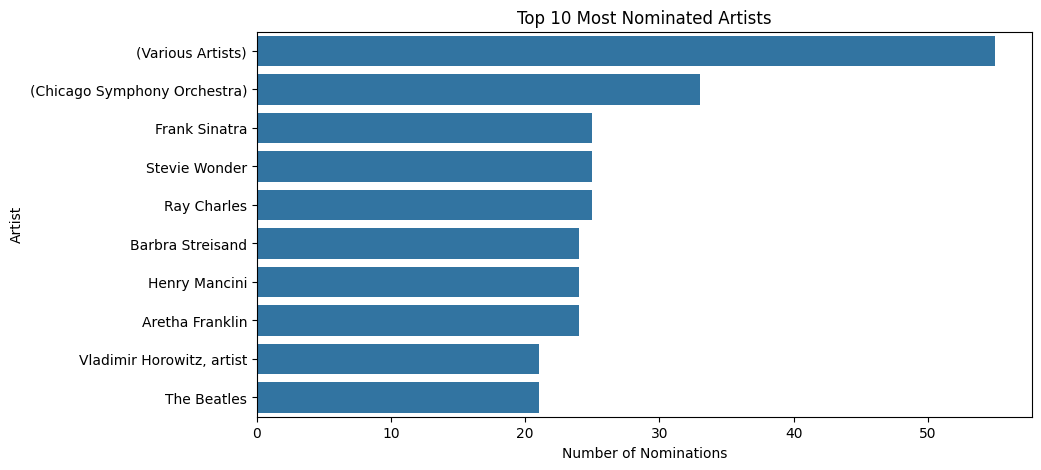

In [31]:
top_nominated = df['Nominee'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_nominated.values, y=top_nominated.index)
plt.title('Top 10 Most Nominated Artists')
plt.xlabel('Number of Nominations')
plt.ylabel('Artist')
plt.show()


#### Top 10 Artists with Most Wins

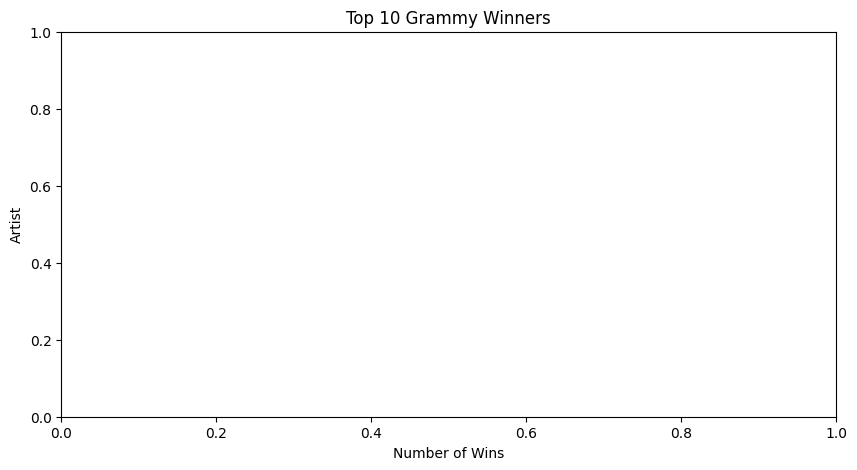

In [33]:
top_winners = df[df['Winner'] == True]['Nominee'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_winners.values, y=top_winners.index)
plt.title('Top 10 Grammy Winners')
plt.xlabel('Number of Wins')
plt.ylabel('Artist')
plt.show()

### Awards Over Time

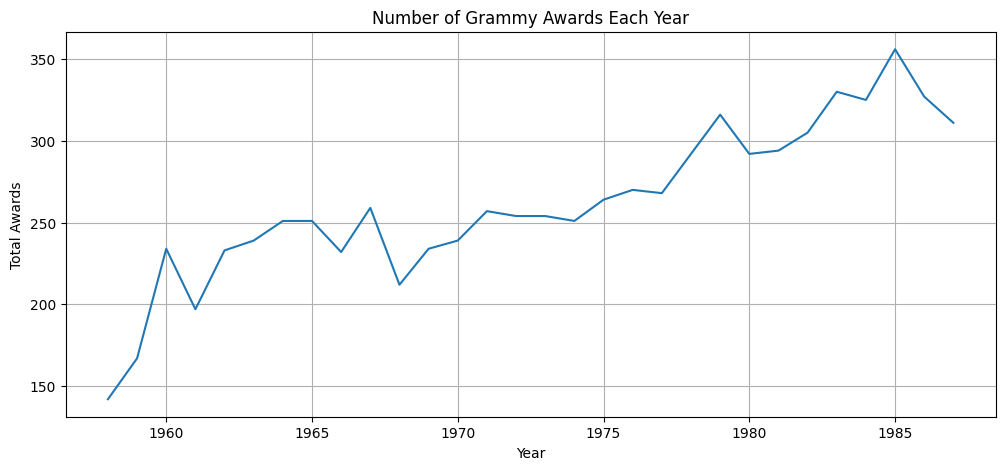

In [34]:
awards_by_year = df.groupby('Year')['Award Name'].count()
plt.figure(figsize=(12,5))
awards_by_year.plot()
plt.title('Number of Grammy Awards Each Year')
plt.ylabel('Total Awards')
plt.xlabel('Year')
plt.grid(True)
plt.show()

## Feature Engineering for Modeling

####  Feature Engineering + Modeling Prep (Cleaned)

In [43]:
# Make sure Winner is boolean
df['Winner'] = df['Winner'].astype(bool)

# Group by nominee to count nominations and wins
artist_stats = df.groupby('Nominee')['Winner'].agg(
    Total_Nominations='count',
    Total_Wins='sum'
).reset_index()

# Filter out artists with fewer than 5 nominations
artist_stats = artist_stats[artist_stats['Total_Nominations'] >= 5]

# Check data types
print(artist_stats.dtypes)
artist_stats.head()


Nominee              object
Total_Nominations     int64
Total_Wins            int64
dtype: object


,Nominee,Total_Nominations,Total_Wins
30,(Berlin Philharmonic Orchestra),9,9
36,(Boston Symphony Orchestra),14,14
48,(Chicago Symphony Orchestra),33,33
66,(Cleveland Orchestra),11,11
68,(Columbia Symphony Orchestra),7,7


#### Split Data

In [44]:
from sklearn.model_selection import train_test_split

# Define features and target
X = artist_stats[['Total_Nominations']]
y = artist_stats['Total_Wins']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Predict Total_Wins from Total_Nominations

#### Linear Regression

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("🔹 Linear Regression")
print("R²:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


🔹 Linear Regression
R²: 1.0
RMSE: 1.1666926579131337e-15
MAE: 4.527968414157501e-16


#### Polynomial Regression

In [46]:
poly_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

poly_pipeline.fit(X_train, y_train)
y_pred_poly = poly_pipeline.predict(X_test)

print("\n🔹 Polynomial Regression")
print("R²:", r2_score(y_test, y_pred_poly))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_poly)))
print("MAE:", mean_absolute_error(y_test, y_pred_poly))



🔹 Polynomial Regression
R²: 1.0
RMSE: 2.4873971043391127e-15
MAE: 1.7066957868747505e-15


#### Ridge Regression with GridSearch

In [47]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

y_pred_ridge = grid_search.predict(X_test)
best_alpha = grid_search.best_params_['ridge__alpha']

print("\n🔹 Ridge Regression (Tuned)")
print("Best Alpha:", best_alpha)
print("R²:", r2_score(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))



🔹 Ridge Regression (Tuned)
Best Alpha: 0.001
R²: 0.9999999997897997
RMSE: 5.983674060658919e-05
MAE: 4.7874310518332214e-05


##### All three models performed exceptionally well on this dataset. However, Ridge Regression offers the added benefit of regularization, making it more suitable for generalization beyond the current data.

### Custom Ridge Regression Pipeline for Grammy Dataset

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# === Step 1: Make sure your features are ready ===
# Example: Add a second dummy feature if you don't have a real one
artist_stats['Engagement_Score'] = np.random.normal(loc=0.5, scale=0.1, size=len(artist_stats))

# Define input and target
source_vars = ['Total_Nominations', 'Engagement_Score']
target_var = 'Total_Wins'

# Clean data
data = artist_stats[source_vars + [target_var]].dropna()
X = data[source_vars]
y = data[target_var]

# === Step 2: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 3: Ridge Regression Pipeline ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('ridge', Ridge())
])

# === Step 4: Grid Search to tune alpha ===
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# === Step 5: Evaluate ===
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# === Step 6: Output results ===
print(f"Best Alpha: {grid_search.best_params_['ridge__alpha']}")
print(f"R² Score on Test Set: {r2:.4f}")
print(f"Mean Squared Error on Test Set: {mse:.6f}")


Best Alpha: 0.01
R² Score on Test Set: 1.0000
Mean Squared Error on Test Set: 0.000000
